In [1]:
import numpy as np
import scipy as sp
import os 
import sys
import importlib
import generate_result_utils as gresu

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
util_path = 'C:/ASM/Dropbox/Developments/Jupyter/Eating/myutils' if 'C:' in os.getcwd() else './myutils'
sys.path.append(util_path)
import my_file_utils as mfileu
import my_steven_free_utils as msfreeu
importlib.reload(gresu)

<module 'generate_result_utils' from 'C:\\ASM\\Dropbox\\Developments\\Jupyter\\Eating\\generate_results\\generate_result_utils.py'>

In [3]:
annots = mfileu.read_file('data', 'free_data_steven_annots.pkl')
ds = mfileu.read_file('data', 'free_data_steven_right.pkl')
fs = mfileu.read_file('features', 'free_features_steven_right.pkl')

In [4]:
all_proba_steven = gresu.get_all_proba(annots, 'baseline_test_proba_bite_steven', 'bite_free', sess_avail=True)
pct_proba_steven = gresu.get_percentile_proba_all(all_proba_steven, fs)

In [5]:
all_proba_our = gresu.get_all_proba(annots, 'our_test_proba_bite_6s', 'bite_free', sess_avail=True)
pct_proba_our = gresu.get_percentile_proba_all(all_proba_our, fs)

s=0
mf = 100000
for p in pct_proba_our:
    if p[0]!=s:
        print()
        s = p[0]
    if p[2]!=99.9:
        continue
    
    print(int(p[0]), int(p[1]), int(p[2]*100)/100, int(p[3]*mf)/mf, int(p[4]*mf)/mf)

pos, tot = 0, 0
for subj in range(len(fs)):
    for sess in range(len(fs[subj])):
        pos +=all_proba_our[subj][sess].shape[0]
        tot += fs[subj][sess].shape[0]
        print(all_proba_our[subj][sess].shape, fs[subj][sess].shape)
print(pos, tot, pos/tot)


In [6]:
def get_tpfp(a, indices):
    if len(indices)==0:
        return 0, 0
    
    a = a[a[:, 2]<=2] #discard meals
    assert len(a)>=1
    
    tps = np.zeros((len(indices), ))    
    for i in range(len(a)):
        si, ei = a[i, 0], a[i, 1]
        cond = (indices[:, 0]>=si) & (indices[:, 1]<=ei)
        tps[cond] = 1
        
    tp = np.sum(tps)
    fp = len(indices) - tp
    return tp, fp    

In [7]:
#for percentile proba th
def get_tpfp_all_percentile(all_proba, percentile, offline=True, steven=False):
    #print("Percentile: ", percentile)
    tp_count, fp_count = 0, 0
    for subj in range(len(annots)):
        for sess in range(len(annots[subj])):
            a = annots[subj][sess]        
            a = msfreeu.process_anntos(len(ds[subj][sess]), a)
            
            proba = all_proba[subj][sess]            
            if steven:            
                indices = proba[:, 0] + 40
                pct_proba = pct_proba_steven
            else:
                indices = proba[:, -2] + 48                
                pct_proba = pct_proba_our
                
                
            cond = (pct_proba[:, 0]==subj) & (pct_proba[:, 1]==sess) & (pct_proba[:, 2]==percentile)                
            assert np.sum(cond) == 1
            proba_th = pct_proba[cond, -2] if offline else pct_proba[cond, -1]
            
            proba = proba[:, -1]
            gesture_indices = gresu.detect_gestures(proba, indices, proba_th = proba_th)
                        
            tp, fp = get_tpfp(a, gesture_indices)            
            #print(subj, sess, " : ", len(gesture_indices), tp, fp)
            
            tp_count += tp
            fp_count += fp

    return tp_count, fp_count

In [8]:
#for fixed proba th
def get_tpfp_all_fixed(all_proba, proba_th, steven=False):
    tp_count, fp_count = 0, 0
    for subj in range(len(annots)):
        for sess in range(len(annots[subj])):
            a = annots[subj][sess]        
            a = msfreeu.process_anntos(len(ds[subj][sess]), a)
                        
            proba = all_proba[subj][sess]
            
            if steven:            
                indices = proba[:, 0] + 40
            else:
                indices = proba[:, -2] + 48
                
            proba = proba[:, -1]                        
            gesture_indices = gresu.detect_gestures_fixed_th(proba, indices, proba_th = proba_th)
                        
            tp, fp = get_tpfp(a, gesture_indices)            
            #print(subj, sess, " : ", len(gesture_indices), tp, fp)
            
            tp_count += tp
            fp_count += fp

    return tp_count, fp_count


In [ ]:
res = []
for proba_th in range(1, 100):    
    tp1, fp1 = get_tpfp_all_fixed(all_proba_our, proba_th/100)
    tp2, fp2 = get_tpfp_all_fixed(all_proba_steven, proba_th/100, steven=True)
    print(proba_th, "TP, FP Our: {}, {},  Steven: {}, {}".format(tp1, fp1, tp2, fp2))

In [12]:
res = []
for p in range(9980, 10000, 2):
    percentile = p/100
    print(percentile)
    tp1, fp1 = get_tpfp_all_percentile(all_proba_our, percentile, offline=True)
    tp2, fp2 = get_tpfp_all_percentile(all_proba_steven, percentile, steven=True, offline=True)
    print(percentile, "TP, FP Our: {}, {},  Steven: {}, {}".format(tp1, fp1, tp2, fp2))

    ftr1 = fp1/tp1
    ftr2 = fp2/tp2
    print(ftr1, ftr2, 1-ftr1/ftr2)    
    res.append([percentile, tp1, fp1, tp2, fp2])    
    

99.8
99.8 TP, FP Our: 1067.0, 662.0,  Steven: 1359.0, 1514.0
0.6204311152764761 1.1140544518027962 0.4430872617828725
99.82
99.82 TP, FP Our: 993.0, 583.0,  Steven: 1278.0, 1357.0
0.5871097683786506 1.0618153364632237 0.44706979809291414
99.84
99.84 TP, FP Our: 929.0, 517.0,  Steven: 1166.0, 1158.0
0.5565123789020452 0.9931389365351629 0.4396429759932775
99.86
99.86 TP, FP Our: 855.0, 438.0,  Steven: 1088.0, 989.0
0.512280701754386 0.9090073529411765 0.4364394302236886
99.88
99.88 TP, FP Our: 785.0, 363.0,  Steven: 982.0, 862.0
0.4624203821656051 0.8778004073319755 0.4732055507115728
99.9
99.9 TP, FP Our: 704.0, 288.0,  Steven: 876.0, 729.0
0.4090909090909091 0.8321917808219178 0.5084175084175084
99.92
99.92 TP, FP Our: 622.0, 223.0,  Steven: 753.0, 580.0
0.35852090032154343 0.7702523240371846 0.5345409690653065
99.94
99.94 TP, FP Our: 512.0, 161.0,  Steven: 622.0, 445.0
0.314453125 0.7154340836012861 0.560472261235955
99.96
99.96 TP, FP Our: 398.0, 110.0,  Steven: 481.0, 311.0
0.27638

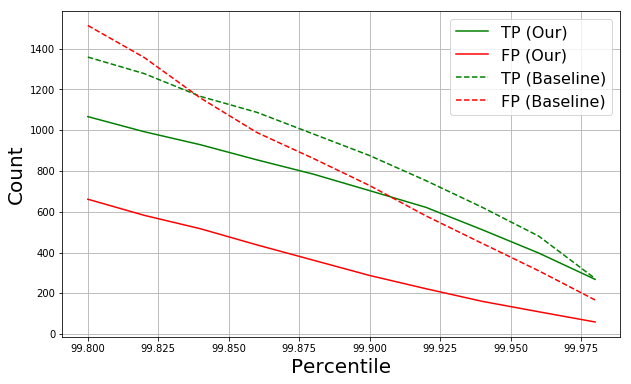

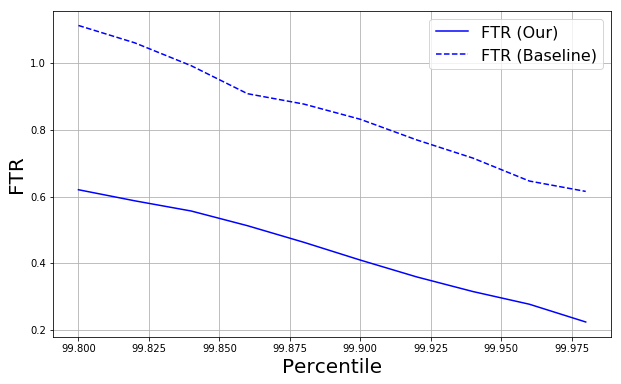

In [14]:
res = np.array(res)
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)  

ax.plot(res[:,0], res[:, 1], label= 'TP (Our)', color='green')
ax.plot(res[:,0], res[:, 2], label= 'FP (Our)', color='red')
ax.plot(res[:,0], res[:, 3], label= 'TP (Baseline)', linestyle='--', color='green')
ax.plot(res[:,0], res[:, 4], label= 'FP (Baseline)', linestyle='--', color='red')

#plt.title(" ", fontsize=20)
plt.xlabel("Percentile", fontsize=20)        
plt.ylabel("Count", fontsize=20)            
plt.legend(fontsize=16)
plt.grid(True)
plt.show()       

ftr1 = res[:, 2]/res[:,1]
ftr2 = res[:, 4]/res[:,3]

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)  

ax.plot(res[:,0], ftr1, label= 'FTR (Our)', color='blue')
ax.plot(res[:,0], ftr2, label= 'FTR (Baseline)', linestyle='--', color='blue')


#plt.title(" ", fontsize=20)
plt.xlabel("Percentile", fontsize=20)        
plt.ylabel("FTR", fontsize=20)            
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
p = pct_proba_our
p = p[p[:, 2]==99.9, :]
plt.hist(p[:, -2], bins=10, edgecolor='black', hatch='/', label='Our', color='green', alpha=0.5,)

p = pct_proba_steven
p = p[p[:, 2]==99.9, :]
plt.hist(p[:, -2], bins=10, edgecolor='black', hatch='+', label='Baseline', color='blue', alpha=0.5,)

plt.title("Histogram (99.9 percentile probability)", fontsize=14)
plt.xlabel('Probabllity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.xlim([0, 1])
plt.show()
